In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [2]:
run_idx = 'hd5-875239'

In [3]:
%ls training/hd5-875239

checkpoint/           model_weights_2.h5*  model_weights_7.h5*
config.json*          model_weights_3.h5*  model_weights_8.h5*
model_weights_0.h5*   model_weights_4.h5*  model_weights_9.h5*
model_weights_10.h5*  model_weights_5.h5*
model_weights_1.h5*   model_weights_6.h5*


In [4]:
with open(f'training/{run_idx}/config.json') as f:
    settings = json.load(f)

In [5]:
data = util.dataset_from_config(settings)

Reduced dataset to 840785 samples per class (1681570 / 2202957)
Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [6]:
model = util.model_from_config(settings)

In [15]:
model.load_weights(f'training/{run_idx}/model_weights_5.h5')

In [16]:
model.weights

[<tf.Variable 'gaussian_adjacency_matrix/sigma:0' shape=(1,) dtype=float32, numpy=array([-2.2632875], dtype=float32)>,
 <tf.Variable 'graph_convolution/dense/kernel:0' shape=(11, 64) dtype=float32, numpy=
 array([[ 3.66840847e-02, -2.37832293e-01, -1.12940088e-01,
          2.54475862e-01, -4.57710475e-02,  1.36600897e-01,
         -6.30537719e-02, -2.30743304e-01, -3.25039476e-01,
         -1.24691255e-01, -2.16224954e-01,  2.67254025e-01,
          8.91924351e-02, -2.16067016e-01,  8.21524952e-03,
          1.68672487e-01, -5.16705632e-01,  4.09662612e-02,
         -1.06688971e-02, -5.16355097e-01,  4.57549617e-02,
          9.49091092e-02, -1.61760792e-01,  1.02388859e-01,
         -9.92624387e-02,  1.62780523e-01,  3.35843891e-01,
         -6.52522892e-02, -1.24843799e-01, -2.10625958e-02,
          2.24422261e-01, -1.98052138e-01,  2.89045237e-02,
          2.99318060e-02, -2.68410772e-01,  1.63066179e-01,
          3.00684035e-01,  1.40447110e-01, -1.52255252e-01,
          1.489

In [17]:
data.get_baseline_accuracy()

0.6503267779515571

In [18]:
#test_idx = data._get_idx('test')
# Also append all idx that were kept from the model
#test_idx.shape

In [19]:
data2_config = settings
settings['dataset']['max_charge'] = None
settings['dataset']['balance_classes'] = None
settings['dataset']['min_track_length'] = None
settings['dataset']['max_cascade_energy'] = None
data2 = util.dataset_from_config(data2_config)

Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [20]:
test_idx = data2._get_idx('test')
test_idx.shape

(220295,)

In [21]:
# Evaluate the model on all the data
batch_size = 16
logits_model = model.predict_generator(data2.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data2.size(dataset='test') / batch_size)), verbose=1)

13769/13769 [==============================] - 2100s 152ms/step


In [22]:
logits_model

array([[0.16602048],
       [0.09750617],
       [0.09194109],
       ...,
       [0.30610916],
       [0.10073299],
       [0.58701843]], dtype=float32)

In [23]:
np.unique(logits_model).shape

(216654,)

In [24]:
y_model = (logits_model >= 0.5).astype(np.int)

In [25]:
np.unique(y_model)

array([0, 1])

In [26]:
y_model = y_model.squeeze()

In [27]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [28]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [29]:
y_model.shape, y_gnd.shape, y_baseline.shape

((220295,), (220295,), (220295,))

In [30]:
total_charge
total_charge.max(), total_charge.min()

(1311.150025099516, 7.0)

In [31]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [32]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [33]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

(2202957,)

In [34]:
(np.abs(pgd_encoding) == 12).sum()

524922

In [35]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [36]:
np.unique(pgd_encoding, return_counts=True)

(array([-16, -14, -12,  12,  14,  16], dtype=int8),
 array([  46767,  467199,  164192,  360730, 1036437,  127632]))

In [37]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

0.618337988440083

In [38]:
np.unique(interaction_types)

array([1, 2], dtype=uint8)

In [39]:
data.file.keys()

<KeysViewHDF5 ['CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DeltaLLH', 'Distances', 'DistancesOffset', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'MuonEnergy', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeVariance', 'TotalCharge', 'TrackLength', 'VertexDeltaLLH', 'VertexX', 'VertexY', 'VertexZ']>

In [40]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [41]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [42]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [43]:
dfs['numu NC']

{'model':          acc  bin_idx  num_samples       ppr  tpr       value
 3   0.546154        3          130  0.453846  0.0    8.849908
 4   0.550459        4          327  0.449541  0.0    9.906457
 5   0.450207        5          482  0.549793  0.0   11.089142
 6   0.503165        6          632  0.496835  0.0   12.413023
 7   0.444961        7          645  0.555039  0.0   13.894955
 8   0.478854        8          733  0.521146  0.0   15.553808
 9   0.496307        9          677  0.503693  0.0   17.410704
 10  0.495509       10          668  0.504491  0.0   19.489286
 11  0.460829       11          651  0.539171  0.0   21.816019
 12  0.458730       12          630  0.541270  0.0   24.420531
 13  0.484034       13          595  0.515966  0.0   27.335983
 14  0.481113       14          503  0.518887  0.0   30.599497
 15  0.513742       15          473  0.486258  0.0   34.252626
 16  0.468447       16          412  0.531553  0.0   38.341886
 17  0.477157       17          394  0.522843 

In [44]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.xlabel('log(Integrated Charge) (pe)')


/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


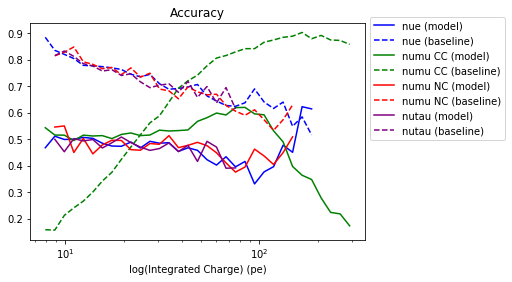

In [45]:
plot_metric('acc', 'Accuracy', )

In [46]:
(y_model == y_gnd).sum() / y_gnd.shape[0]

0.5089266665153545

In [47]:
(y_baseline == y_gnd).sum() / y_gnd.shape[0]

0.6158560112576318

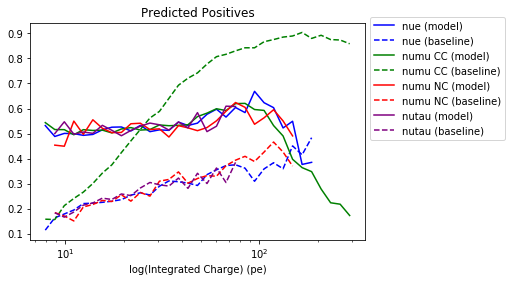

In [48]:
plot_metric('ppr', 'Predicted Positives')

In [49]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


(array([  15,  455, 1550, 3179, 4701, 5964, 6505, 6722, 6417, 5999, 5752,
        5133, 4529, 3866, 3372, 2994, 2620, 2223, 1942, 1652, 1446, 1197,
        1044,  886,  765,  623,  505,  424,  314,  306,  217,  183,  142,
         111,   74,   66,   42,   31,   23,   12,    6,    9,    1,    4,
           7,    1,    1]),
 array([  19,  538, 1836, 4093, 6086, 7511, 8517, 9375, 9176, 8999, 8646,
        8259, 7636, 6971, 6541, 5913, 5341, 4603, 4262, 3880, 3202, 2777,
        2462, 2078, 1739, 1382, 1066,  842,  691,  517,  356,  250,  191,
         152,  119,   69,   58,   37,   23,   20,   13,   11,    4,    1,
           1,    1,    1]))

Text(0.5, 0, 'log(Integrated Charge) (pe)')

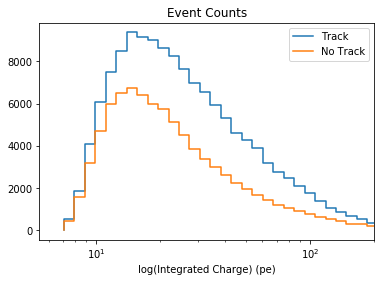

In [50]:
fig = plt.figure()
plt.xscale('log')
plt.step(bins[bins_track], bin_counts_track, label='Track')
plt.step(bins[bins_non_track], bin_counts_non_track, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [51]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

array([       nan, 0.45454545, 0.54371585, 0.51602564, 0.51567568,
       0.49527959, 0.51566784, 0.51246347, 0.51382596, 0.50258565,
       0.51834025, 0.52382573, 0.51396848, 0.51608527, 0.53446809,
       0.53135536, 0.53290291, 0.53529572, 0.56768838, 0.58156271,
       0.59902658, 0.59186472, 0.61957091, 0.62044232, 0.59596662,
       0.59243697, 0.53202479, 0.49041096, 0.39739414, 0.36418511,
       0.34816754, 0.27881041, 0.22395833, 0.21830986, 0.17322835,
       0.14130435, 0.09259259, 0.29787234, 0.07407407, 0.125     ,
       0.2       , 0.53846154, 0.375     , 0.        , 1.        ,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.45454545, 0.54371585, 0.51602564, 0.51567568,
       0.49527959, 0.51566784, 0.51246347, 0.51382596, 0.50258565,
       0.51834025, 0.52382573, 0.51396848, 0.51608527, 0.53446809,
       0.53135536, 0.53290291, 0.53529572, 0.56768838, 0.58156271,
       0.59902658, 0.59186472, 0.61957091, 0.62044232, 0.59596

In [52]:
total_charge_sorted = np.sort(total_charge)

In [19]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [20]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [22]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

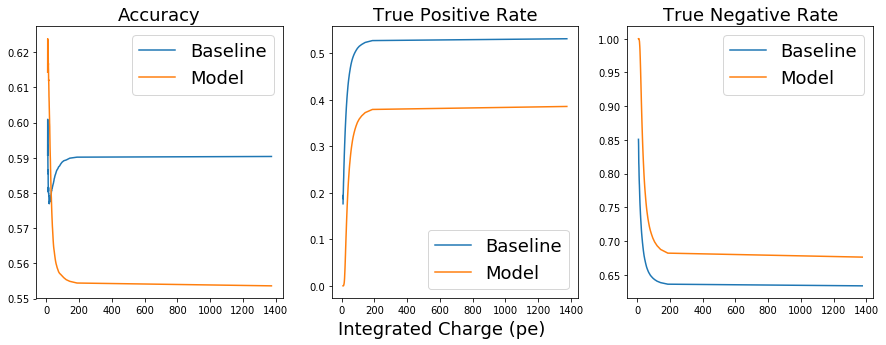

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



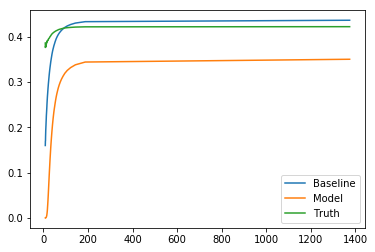

In [24]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

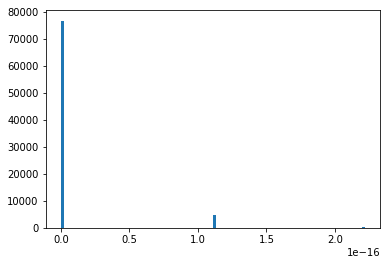

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

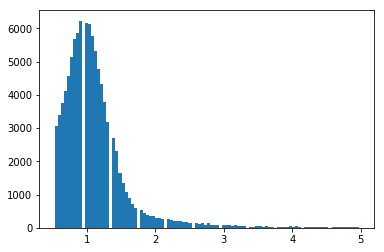

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526